# Importing necessary libraries

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Deleting the mask images

In [6]:
#Here we are deleting the mask data as we don't need those to train our moodels.

image_path = '/content/drive/MyDrive/Colab Notebooks/Freelance Project/Breast_cancer'
for i in os.listdir(image_path):
    for j in os.listdir(os.path.join(image_path, i)):
        if 'mask' in j:
            os.remove(image_path+ '/'+  i +'/'+ j)  


# loading the dataset

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [9]:
img_dir = '/content/drive/MyDrive/Colab Notebooks/Freelance Project/Breast_cancer'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    img_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
)

Found 780 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['benign', 'malignant', 'normal']

# Displaying the dataset

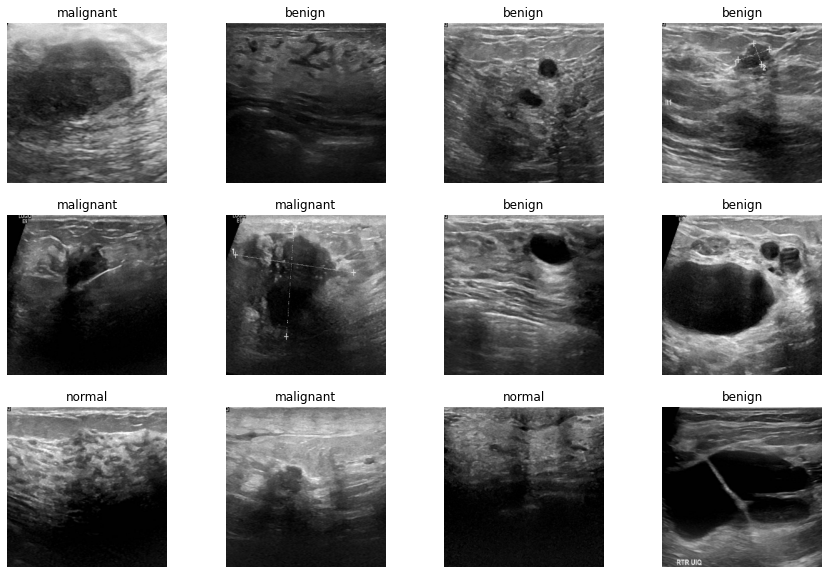

In [11]:
plt.figure(figsize = (15,10)) #setting the figure size
for image_batch, label_batch in dataset.take(1): #taking 1 batch of the dataset
    for i in range(12):
        ax = plt.subplot(3,4, i+1)#for creating the subplot
        plt.imshow(image_batch[i].numpy().astype('uint8')) #displaying the dataset
        plt.title(class_names[label_batch[i]]) #for the image label
        plt.axis('off')
        

# Train_test_split

In [12]:
def train_test_split(ds):
    
    train_split = .8 #defining the trainsplit
    val_split = .1  #defining the validationsplit
    shuffle = True,
    shuffle_size = 1000
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    ds_size = len(ds) #number of batchs in the actual dataset
    train_size = int(ds_size * train_split) # trainsize
    val_size = int(ds_size * val_split) #valsize
    
    train_ds = ds.take(train_size)  #storing the train data 
    val_ds = ds.skip(train_size).take(val_size) #storing the validation data
    test_ds = ds.skip(train_size).skip(val_size) #storing the test data
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = train_test_split(dataset)

# Creating some processing layers

In [14]:
rescalling_resizing = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

image_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(.2)
])

# Creating CNN models

In [15]:
for x, y in train_ds.take(1):
    print(x.shape)

(32, 256, 256, 3)


In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = Sequential([
    rescalling_resizing,
    image_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

In [17]:
model.build(input_shape = input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='acc',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='acc',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


In [19]:
#Model compilation
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])


In [20]:
# Model  training
history= model.fit(train_ds,
                   batch_size = BATCH_SIZE,
                                epochs=10,
                                validation_data = val_ds,
                                callbacks=callbacks_list
                                )

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.0409 - accuracy: 0.5452


Epoch 1: val_accuracy improved from -inf to 0.64062, saving model to ./model.h5


20/20 [==============================] - 96s 4s/step - loss: 1.0409 - accuracy: 0.5452 - val_loss: 0.9981 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 1.0052 - accuracy: 0.5613


Epoch 2: val_accuracy did not improve from 0.64062


20/20 [==============================] - 89s 4s/step - loss: 1.0052 - accuracy: 0.5613 - val_loss: 0.9812 - val_accuracy: 0.5781 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.9857 - accuracy: 0.5613


Epoch 3: val_accuracy did not improve from 0.64062


20/20 [==============================] - 91s 4s/step - loss: 0.9857 - accuracy: 0.5613 - val_loss: 1.0341 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.5597


Epoch 4: val_accuracy did not improve from 0.64062


20/20 [==============================] - 90s 4s/step - loss: 0.9734 - accuracy: 0.5597 - val_loss: 0.8758 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.5565


Epoch 5: val_accuracy did not improve from 0.64062


20/20 [==============================] - 91s 4s/step - loss: 0.9549 - accuracy: 0.5565 - val_loss: 0.8559 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 6/10
20/20 [==============================] - ETA: 0s - loss: 0.9695 - accuracy: 0.5839


Epoch 6: val_accuracy did not improve from 0.64062


20/20 [==============================] - 91s 4s/step - loss: 0.9695 - accuracy: 0.5839 - val_loss: 0.9116 - val_accuracy: 0.6136 - lr: 0.0010
Epoch 7/10
20/20 [==============================] - ETA: 0s - loss: 0.9076 - accuracy: 0.6032


Epoch 7: val_accuracy did not improve from 0.64062


20/20 [==============================] - 92s 4s/step - loss: 0.9076 - accuracy: 0.6032 - val_loss: 0.9453 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 8/10
20/20 [==============================] - ETA: 0s - loss: 0.9035 - accuracy: 0.5919


Epoch 8: val_accuracy did not improve from 0.64062


20/20 [==============================] - 88s 4s/step - loss: 0.9035 - accuracy: 0.5919 - val_loss: 1.1888 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 9/10
20/20 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.6129


Epoch 9: val_accuracy did not improve from 0.64062


20/20 [==============================] - 88s 4s/step - loss: 0.9098 - accuracy: 0.6129 - val_loss: 0.9107 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 10/10
20/20 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.6210


Epoch 10: val_accuracy did not improve from 0.64062


20/20 [==============================] - 90s 4s/step - loss: 0.8906 - accuracy: 0.6210 - val_loss: 1.0643 - val_accuracy: 0.5938 - lr: 0.0010


In [21]:
# function for plotting the model history

def perf_plot(history):
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  

  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

  ax[0].set_title('Training Accuracy vs. Epochs')
  ax[0].plot(train_accuracy, color = 'blue', marker = 'o', markerfacecolor = 'red',markersize = 10, label='Train Accuracy')
  ax[0].plot(val_accuracy, color = 'red', marker = 'o', markerfacecolor = 'blue',markersize = 10, label='Validation Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(loc='best')

  ax[1].set_title('Training/Validation Loss vs. Epochs')
  ax[1].plot(train_loss, 'o-', label='Train Loss')
  ax[1].plot(val_loss, 'o-', label='Validation Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(loc='best')


  plt.tight_layout()
  plt.show()

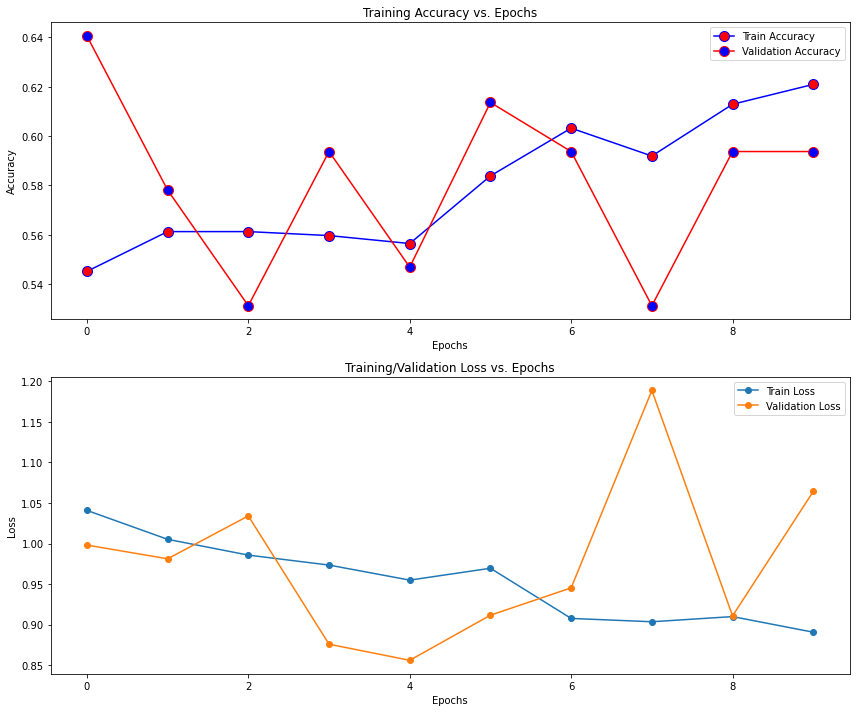

In [22]:
perf_plot(history)

# Visualizing and Evaluating the model performance on text data

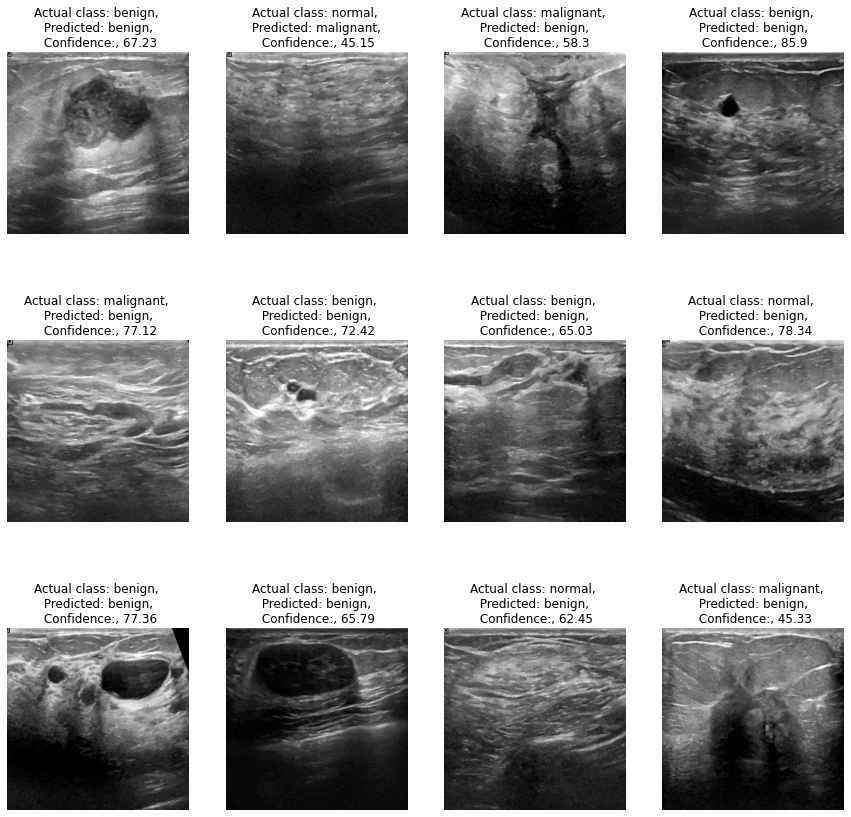

In [23]:
plt.figure(figsize = (15,15)) #setting the figure size
#plt.figure(figsize =(15, 10))
for image_batch, label_batch in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        image = image_batch[i].numpy().astype('uint8')
        ex_image = np.expand_dims(image, axis = 0) #expanding the dimension from 3D to 4D
        Actual_label = class_names[label_batch[i].numpy()] #converting into numpy from tensor and Actual class label)
        plt.imshow(image)#printing the image
        prediction = model.predict(ex_image) #prediction on the test image
        predicted_label = class_names[np.argmax(prediction)] #Predicted class name
        confidence = round(100 * np.max(prediction), 2) # Confidence on prediction
        plt.title(f"Actual class: {Actual_label}, \n Predicted: {predicted_label}, \n Confidence:, {confidence}")
        plt.axis('off')